Start from design and AF2 models of DHR39, DHR62, and DHR82 selected by AF2, nstruct 100, with PPI upweighter

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: sofia


In [2]:
import os, stat

ala_pen = 2
met_pen = 1
np_pen = 3

nstruct = 100
def create_tasks(selected):
    with open(selected, "r") as f:
        for i, line in enumerate(f):
            tasks = {"-s": line.rstrip()}
            tasks["-ala_pen"] = ala_pen
            tasks["-met_pen"] = met_pen
            tasks["-np_pen"] = np_pen
            yield tasks

selected_af2 = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_af2_sample_firstmodel.list"
selected_des = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_design_sample.list"

msd_py = "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/msd.py"

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

slurm_dir = os.path.join(os.getcwd(), '05_two_state/slurm_logs')

tasklist = "05_two_state/run_3/05_msd_tasks.cmds"
run_sh = """#!/usr/bin/env bash \n#SBATCH -J 05_two_state \n#SBATCH -e {slurm_dir}/05_two_state-%J.err \n#SBATCH -o {slurm_dir}/05_two_state-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=8G \n
source activate /projects/crispy_shifty/envs/crispy\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
    slurm_dir=slurm_dir, queue='short', jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
)
shell = "05_two_state/run_3/05_msd.sh"
with open(shell, "w+") as f:
    print(run_sh, file=f)
st = os.stat(shell)
os.chmod(shell, st.st_mode | stat.S_IEXEC)
with open(tasklist, "w+") as f:
    for _ in range(nstruct):
        for tasks in create_tasks(selected_af2):
            tasks["-subfolder"] = 'af2_decoys'
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)
        for tasks in create_tasks(selected_des):
            tasks["-subfolder"] = 'design_decoys'
            args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
            cmd = f"{msd_py} {args_}"
            print(cmd, file=f)

# Let's go
print("Run the following commands")
print(f"sbatch -a 1-$(cat {tasklist} | wc -l) {shell}")

Run the following commands
sbatch -a 1-$(cat 05_two_state/run_3/05_msd_tasks.cmds | wc -l) 05_two_state/run_3/05_msd.sh


In [3]:
# %%time

# retrieve the JSONs containing scores

import json

for model_type in ['af2', 'design']:

    output_paths = glob(f"05_two_state/run_3/{model_type}_decoys/*.json")

    scores = {}
    errors = []

    for test in tqdm(output_paths):
        key = test.replace("json", "pdb")
        try:
            with open(test, "r") as f:
                values = json.load(f)
            scores[key] = values
        except json.JSONDecodeError:
            errors.append(test)

    print(len(errors))

    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.T
    output_path = "05_two_state/run_3"
    output_file = os.path.join(output_path, f"{model_type}_scores.json")
    scores_df.to_json(output_file)

100%|██████████| 1194/1194 [00:00<00:00, 7463.34it/s]


0


100%|██████████| 1194/1194 [00:00<00:00, 8108.66it/s]


0


In [4]:
def histplot_df(df, hue_col=None, hue_order=None):
    sns.set(
        context="talk",
        # font_scale=1,  # make the font larger; default is pretty small
        style="ticks",  # make the background white with black lines
        palette="colorblind",  # a color palette that is colorblind friendly!
    )

    fig, axs = plt.subplots(5, 6, figsize=(24,20))

    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
    #     "parent",
    ]

    for ax, col in zip(axs.flatten(),cols):
        sns.histplot(
            data=df,
            x=col,
            ax=ax,
            hue=hue_col,
            hue_order=hue_order,
        )

    plt.tight_layout()

In [5]:
def print_scores(df):
    cols = [
        "score_per_res_X",
        "score_per_res_Y",
        "Y-X",
        "A_Y-X",
        "B_Y-X",
        "ddg_Y",
        "cms_Y",
        "sasa_Y",
        "sc_int_Y",
        "sc_X",
        "sc_Y",
        "ibuns_Y",
        "vbuns_X",
        "vbuns_Y",
        "sap_X",
        "sap_Y",
        "sap_A_X",
        "sap_B_X",
        "wnm_hlx_X",
        "wnm_hlx_Y",
        "wnm_all_A_X",
        "wnm_all_A_Y",
        "wnm_all_B_X",
        "wnm_all_B_Y",
        "mismatch_probability_X",
        "mismatch_probability_Y",
        "geometry_X",
        "geometry_Y",
        "geometry_loop_X",
        "geometry_loop_Y",
        "parent",
    ]
    print_df = df[cols]

    from IPython.display import display
    with pd.option_context(
        # 'display.max_rows', 5,
        'display.max_columns', None,
        # 'display.width', 1000,
        # 'display.precision', 3,
        # 'display.colheader_justify', 'left'
    ):
        display(print_df)

In [6]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        # print(filtered_series)
        # print(parent_scores)
        # print(parent_scores - filtered_series < cutoff)
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [22]:
def copy_designs(df, out_dir):
    import os
    import shutil
    # Copy designs to a folder
    os.makedirs(out_dir, exist_ok=True)
    
    keys = ['parent',
            'Y-X',
            'sap_A_X',
            'sap_B_X',
            'sap_Y',
            'sc_int_Y',
            'vbuns_Y',
            'wnm_hlx_X',
            'wnm_hlx_Y',
            'wnm_all_A_X',
            'wnm_all_B_X',
            'wnm_all_A_Y',
            'wnm_all_B_Y',
           ]

    for index, row in df.iterrows():
        filename = out_dir
        for key in keys:
            val = row[key]
            if type(val) != str:
                val = f'_{val:.03f}'
            filename += val
        filename += '.pdb'
    #     print(filename)
        shutil.copy(index, filename)

In [8]:
def get_parents(df):
    parents = []
    for key, row in df.iterrows():
        parent = row['parent']
        if parent not in parents:
            parents.append(parent)
    print(len(parents))
    return parents

#### Analyze and filter MSD starting from AF2 models ####

In [38]:
output_path = "05_two_state/run_3"
output_file = os.path.join(output_path, "af2_scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,total_score_X,total_score_Y,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y
05_two_state/run_3/af2_decoys/c112ec003cba3cdff5ff75fa6583d72348575374d892abaf.pdb,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,106.714005,48.640388,48.715912,loop_match,loop_remodel,11.312505,253.735657,403.629120,...,-865.328064,-830.857117,1,5,0.402210,0.361855,0.435452,0.477818,0.136842,0.129235
05_two_state/run_3/af2_decoys/c6361df9653a95de78a2a7d2325d2b17f11ca53a7cd4d4e6.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.000000,638.672119,1020.770874,...,-1295.348022,-1314.942505,1,3,0.266406,0.557818,0.362510,5.000000,0.143477,0.118914
05_two_state/run_3/af2_decoys/56cf965044fcafa44484c43728302a380cbfee56d47d82e1.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,-1332.384888,-1356.105469,2,6,0.274339,1.490953,0.365675,5.000000,0.118120,0.133905
05_two_state/run_3/af2_decoys/cdf4bf45eb41071b173b5e9790c1d35880f26dbd616f648b.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,-1325.932129,-1332.382080,3,1,0.314622,1.324314,0.343203,1.394819,0.110894,0.185052
05_two_state/run_3/af2_decoys/23ee9c4b2b9fcaa93a6f27a1ab12e43b202f1aef79371fef.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.000000,638.672119,1020.770874,...,-1349.040527,-1362.647217,3,3,0.318271,0.558678,0.312638,5.000000,0.099660,0.121894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_3/af2_decoys/ef1aa953767ae8b845c8d5f07467380d67093d17e35d90a1.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,-1359.733765,-1327.304810,3,4,0.301787,0.622244,0.304806,5.000000,0.115823,0.177155
05_two_state/run_3/af2_decoys/a80c96a46d0bfb299ed85ae9ca970253180aa303a0fdc645.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.000000,623.278503,1033.097168,...,-1290.072266,-992.399231,1,6,0.335949,0.537225,0.246962,0.813977,0.140045,0.148778
05_two_state/run_3/af2_decoys/ccf46ab6eca4988d38db9e73b67094cbd5cb0e6691eaa8aa.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,163.946396,70.339119,70.339119,loop_match,loop_remodel,-1.000000,623.278503,1033.097168,...,-1321.529785,-1184.788574,1,3,0.310077,0.676365,0.246819,0.895512,0.124270,0.152612
05_two_state/run_3/af2_decoys/74af25846d31008cb79e8a7eb2cbcb7e55d32dda48fb6e56.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.000000,481.578278,710.629456,...,-942.645264,-981.415283,0,1,0.243716,0.493751,0.226345,0.374021,0.105663,0.177958


In [39]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

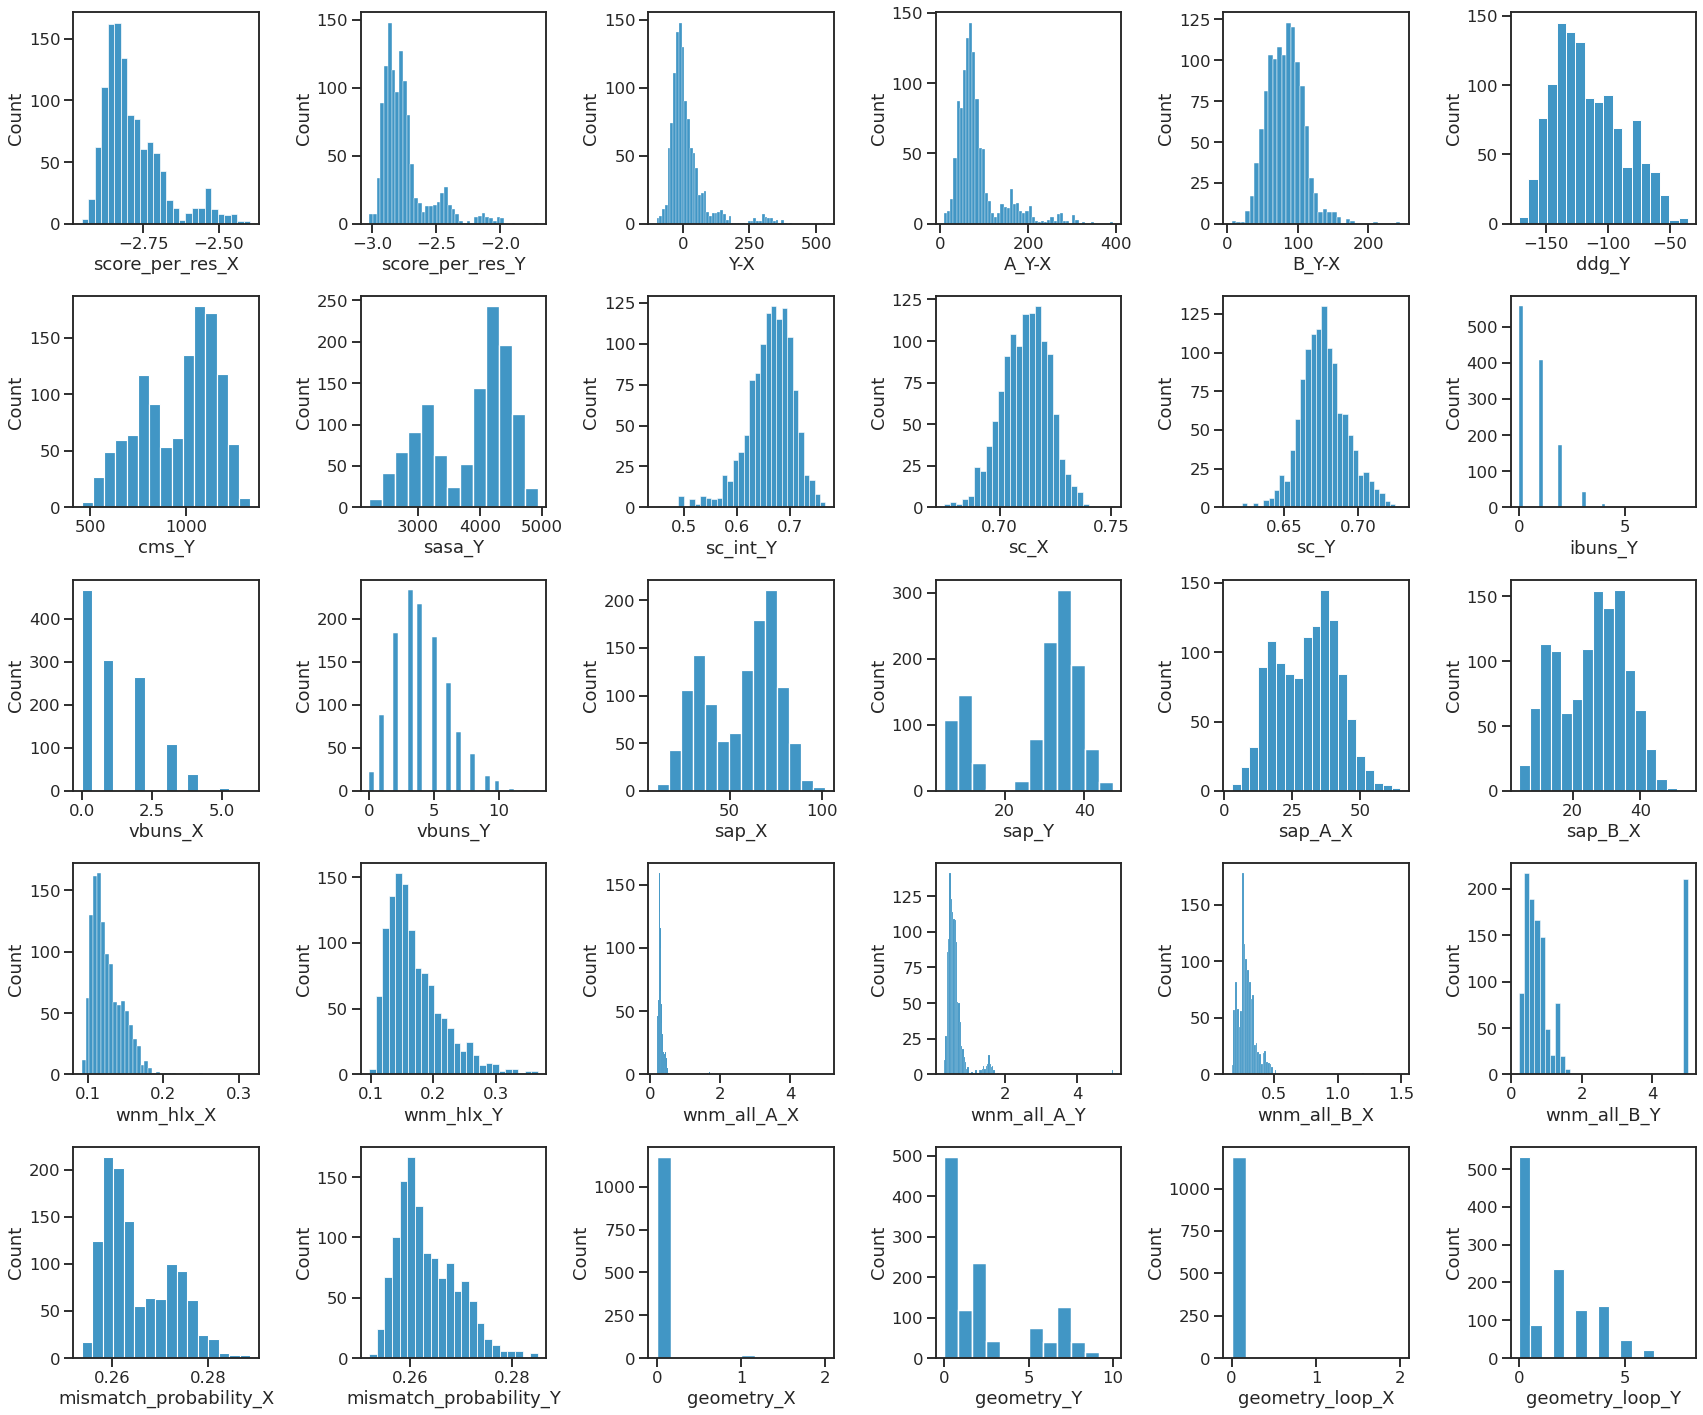

In [11]:
histplot_df(scores_df)

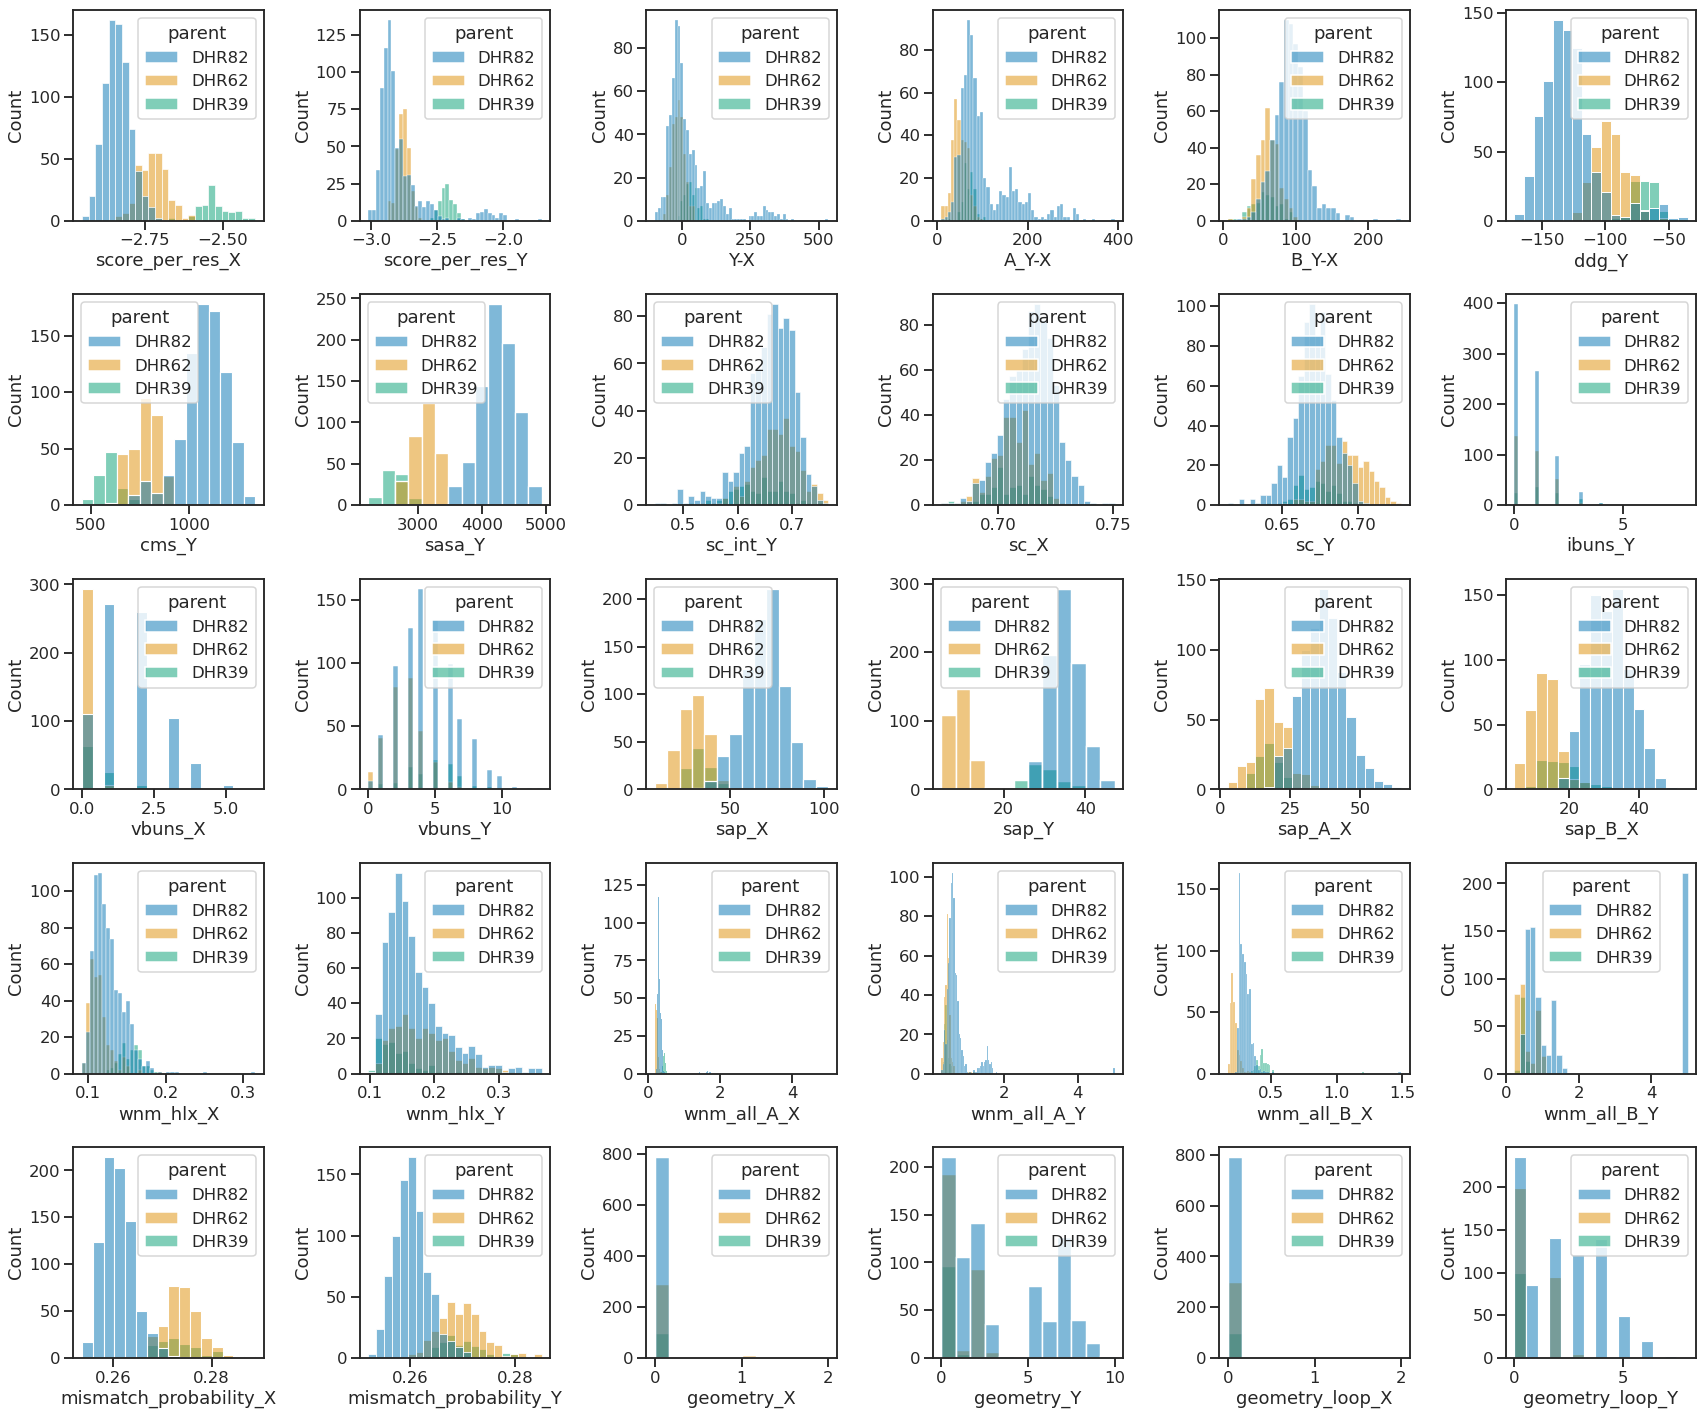

In [13]:
histplot_df(scores_df, 'parent', ['DHR82', 'DHR62', 'DHR39'])

In [15]:
# Filter designs- global filter

cutoffs = [('Y-X', -20, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.7, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

11


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/af2_decoys/c383e7f15a329eef3c516191455a8c62c6a9a8138741d2ec.pdb,-2.727622,-2.813951,-29.697144,24.766937,61.966187,-90.801353,682.697693,2868.747314,0.719724,0.701058,0.705810,0,0,1,35.094906,9.141383,25.508024,9.586878,0.126078,0.190158,0.491525,0.485921,0.192088,0.439448,0.271300,0.267357,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/b3bb386143a6e2e4702d7f712ce881c6e4f3b1f1bd3957af.pdb,-2.709105,-2.772552,-21.825928,49.113953,46.817719,-98.070786,754.835388,2911.668457,0.712116,0.712060,0.696068,0,0,2,23.738535,7.265749,8.211075,15.527452,0.136346,0.169166,0.226515,0.487859,0.211282,0.360278,0.279273,0.281190,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/6f5fc740ee0bd9c8e2016dca9169880a6433c28bd9922eaa.pdb,-2.692316,-2.789707,-33.502502,37.337585,48.583344,-89.325165,754.401123,2817.594482,0.719735,0.705586,0.670667,1,0,1,27.107706,9.814967,11.716299,15.391399,0.165447,0.195860,0.243899,0.482238,0.238793,0.420178,0.274914,0.270089,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/0f7c5afb309eb0832cf0425bbc127d9fb4e42dcfb19dbc85.pdb,-2.686407,-2.851776,-56.886658,39.527649,40.446625,-113.843987,827.501648,3156.748779,0.712505,0.706911,0.705214,1,0,1,39.884087,7.229101,30.256035,9.628072,0.114250,0.144708,0.213105,0.369671,0.215067,0.541134,0.276880,0.272625,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/bcaf65a21ef43d2f39b27ad7f5cb231fd94733d9635d8567.pdb,-2.708399,-2.767168,-20.216370,57.260223,60.746460,-106.629059,896.758667,3439.139160,0.704270,0.715230,0.713026,2,0,2,37.931667,10.013942,24.900320,13.031366,0.108521,0.140526,0.238025,0.627411,0.193835,0.726890,0.272701,0.264532,0,2,0,2,DHR62
05_two_state/run_3/af2_decoys/896e4ae4a491033e508e8f3d6baddc8055d2112b060b2519.pdb,-2.686466,-2.770751,-28.994202,58.524597,57.135437,-116.119591,838.865845,3165.056641,0.734543,0.702622,0.685147,0,0,1,30.261919,7.138339,17.875710,12.386220,0.131913,0.130676,0.275524,0.412853,0.220413,0.343815,0.272672,0.269604,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/004d3f051d6deb5565ea20884041079a13c19bdf4639a48e.pdb,-2.760247,-2.824306,-22.036072,50.415985,41.674225,-99.246803,749.157959,2935.305908,0.732195,0.709785,0.693369,1,0,2,29.206484,14.171591,21.297678,7.908798,0.099754,0.164470,0.197168,0.467618,0.199162,0.356155,0.267150,0.267094,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/c50eb09e406c0efc501a9f721f9c473b6843077269818292.pdb,-2.708010,-2.801384,-32.120667,47.462494,58.320526,-111.440201,818.130127,3212.082275,0.716648,0.710507,0.681221,0,0,2,40.958534,7.369538,22.035957,18.922558,0.107525,0.120163,0.213806,0.443371,0.264293,0.446389,0.276886,0.274168,0,0,0,0,DHR62
05_two_state/run_3/af2_decoys/879ca6a061cd5ecfd836406f772456f1bf1aa3473e6724bf.pdb,-2.746389,-2.834821,-41.032349,42.439270,107.979187,-145.433624,1148.855469,4192.154297,0.719270,0.697635,0.674961,0,0,2,58.216286,33.871487,32.803463,25.412851,0.123501,0.165212,0.242875,0.449852,0.309504,0.519651,0.260805,0.263141,0,0,0,0,DHR82
05_two_state/run_3/af2_decoys/6306fddd32c5c8463b7b6428676c645d4319aa708a59982d.pdb,-2.677919,-2.741335,-21.815125,39.570557,45.581238,-76.053131,651.266602,2759.668945,0.736747,0.691774,0.693427,1,0,1,19.375219,15.004452,8.633994,10.741236,0.111129,0.166908,0.239751,0.377942,0.270569,0.333332,0.271127,0.271054,0,0,0,0,DHR62


In [17]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.65, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df_2 = filter_df(scores_df, cutoffs)
print_scores(global_df_2[global_df_2['parent']=='DHR82'])
print_scores(global_df_2[global_df_2['parent']=='DHR39'])

37


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/af2_decoys/879ca6a061cd5ecfd836406f772456f1bf1aa3473e6724bf.pdb,-2.746389,-2.834821,-41.032349,42.43927,107.979187,-145.433624,1148.855469,4192.154297,0.71927,0.697635,0.674961,0,0,2,58.216286,33.871487,32.803463,25.412851,0.123501,0.165212,0.242875,0.449852,0.309504,0.519651,0.260805,0.263141,0,0,0,0,DHR82


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/af2_decoys/9db86be6febef14afded6e7be9e430cc1088556cfbdc5e42.pdb,-2.443139,-2.477587,-11.574585,25.619904,60.758179,-76.438454,637.498718,2623.65918,0.657193,0.700972,0.674235,0,0,2,37.772377,28.036943,18.977093,18.795286,0.144967,0.104735,0.425168,0.503379,0.515588,0.531912,0.273858,0.270298,0,0,0,0,DHR39


In [19]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.6, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 4, 0),
]

global_df_3 = filter_df(scores_df, cutoffs)
print_scores(global_df_3[global_df_3['parent']=='DHR82'])
print_scores(global_df_3[global_df_3['parent']=='DHR39'])

# increasing the vbuns_Y cutoff to 5 will get you some DHR82 designs... hmm...
# seems there is a tradeoff between vbuns_Y and sc_int_Y

82


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/af2_decoys/a877ccf3f8ee7cd7365708ea445a041977eb4c8282331eb9.pdb,-2.807856,-2.842911,-16.265381,76.935913,91.130737,-143.501572,1056.536011,4317.528320,0.626595,0.718998,0.671232,0,1,3,62.466484,36.833740,33.035007,29.431499,0.125716,0.190874,0.274945,0.535186,0.377006,0.558285,0.260109,0.260816,0,1,0,1,DHR82
05_two_state/run_3/af2_decoys/dfef6fdcea5de7840f2e153196d32f0103304c328988024b.pdb,-2.827314,-2.879873,-24.387329,42.983704,90.671021,-125.790405,904.082703,3945.555664,0.636480,0.712542,0.669358,0,1,3,59.724659,35.125168,33.613216,26.111523,0.091661,0.186775,0.304518,0.675039,0.304413,0.672435,0.260123,0.260898,0,1,0,1,DHR82
05_two_state/run_3/af2_decoys/879ca6a061cd5ecfd836406f772456f1bf1aa3473e6724bf.pdb,-2.746389,-2.834821,-41.032349,42.439270,107.979187,-145.433624,1148.855469,4192.154297,0.719270,0.697635,0.674961,0,0,2,58.216286,33.871487,32.803463,25.412851,0.123501,0.165212,0.242875,0.449852,0.309504,0.519651,0.260805,0.263141,0,0,0,0,DHR82
05_two_state/run_3/af2_decoys/37da35f169629b1ab52ad25c38fbc875a16a53c7688df2e2.pdb,-2.846731,-2.914550,-31.468018,57.297180,83.966003,-127.443863,1102.124634,4352.416016,0.623127,0.720983,0.670724,1,2,1,64.831245,34.277065,31.807209,33.024036,0.119717,0.145205,0.230571,0.621706,0.427338,0.691031,0.260684,0.259542,0,2,0,2,DHR82
05_two_state/run_3/af2_decoys/739415d17791f05f45cf49fe50ef19c711ced62e3db9cf74.pdb,-2.837570,-2.897235,-27.684814,69.095764,81.683594,-140.171021,1091.674072,4136.842285,0.647846,0.711807,0.662768,1,2,2,58.426067,26.165485,27.556364,30.869715,0.155935,0.159472,0.270916,0.622702,0.290400,0.502422,0.255645,0.255170,0,0,0,0,DHR82


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/af2_decoys/9db86be6febef14afded6e7be9e430cc1088556cfbdc5e42.pdb,-2.443139,-2.477587,-11.574585,25.619904,60.758179,-76.438454,637.498718,2623.65918,0.657193,0.700972,0.674235,0,0,2,37.772377,28.036943,18.977093,18.795286,0.144967,0.104735,0.425168,0.503379,0.515588,0.531912,0.273858,0.270298,0,0,0,0,DHR39


In [23]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected/AF2_DHR62/'
copy_designs(global_df, out_dir)

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected/AF2_DHR82/'
copy_designs(global_df_2[global_df_2['parent']=='DHR82'], out_dir)
copy_designs(global_df_3[global_df_3['parent']=='DHR82'], out_dir)

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected/AF2_DHR39/'
copy_designs(global_df_2[global_df_2['parent']=='DHR39'], out_dir)

In [40]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_3/af2_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

369


#### Analyze and filter MSD starting from design models ####

In [24]:
output_path = "05_two_state/run_3"
output_file = os.path.join(output_path, "design_scores.json")
scores_df = pd.read_json(output_file)
scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,vbuns_X,vbuns_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,wnm_hlx_X,wnm_hlx_Y,remodel_after_loop_A,remodel_before_loop_A
05_two_state/run_3/design_decoys/900bf73d7a2f0dac70e8cc2cce43bb5478b5fdb5a8302391.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.000000,638.672119,1020.770874,...,2,7,0.265673,0.515699,0.371852,1.291791,0.171150,0.148529,NaN,NaN
05_two_state/run_3/design_decoys/09d2ce3c4f2d2285b4378cf5003e4027c812eabc812099e0.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.000000,639.776733,1027.007690,...,3,5,0.304272,0.419125,0.311282,0.809054,0.128027,0.184554,NaN,NaN
05_two_state/run_3/design_decoys/1f872f87d061286ac3ea9fc7b2648a8bc9ceb16f71038d43.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,0,3,0.281416,0.771704,0.272711,1.017485,0.097871,0.097601,NaN,NaN
05_two_state/run_3/design_decoys/c98124b9c532eed01e765b2f6cee3e2a51226c1fbce3ae83.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,150.263260,70.339119,70.339119,loop_match,loop_remodel,-1.000000,638.672119,1020.770874,...,2,8,0.284344,0.616378,0.261430,1.260703,0.109549,0.141764,NaN,NaN
05_two_state/run_3/design_decoys/6c243a66e47c2aa5546a65b5d8b20947651af64d43cda7f6.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.000000,594.001953,1018.254456,...,2,5,0.289234,0.716372,0.343650,0.889840,0.108832,0.258132,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
05_two_state/run_3/design_decoys/a1d07eecbe9f98e575d6f8cd5ae5ad12695abc8fd0f17711.pdb,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,XAAAAAAAAAAAAAAAAGBBAAAAAAAAAAAAAAAAAAAGGBAAAA...,106.714005,48.640388,48.715912,loop_match,loop_remodel,11.312505,253.735657,403.629120,...,0,8,0.455603,0.385028,0.462719,0.796874,0.159852,0.176604,NaN,NaN
05_two_state/run_3/design_decoys/5ce65ac7ec9dbb044d5ffb34941a0c465f4183d4c03a13b9.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,152.276901,70.339119,70.339119,loop_match,loop_match,-1.000000,661.585510,1067.979858,...,3,2,0.278902,0.681158,0.317939,0.888766,0.154018,0.123917,NaN,NaN
05_two_state/run_3/design_decoys/6a23a935226cc539768581748ea797654f68913572a79ea3.pdb,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.146545,52.073273,52.073273,loop_remodel,loop_remodel,-1.000000,469.840790,695.218018,...,0,2,0.205112,0.898741,0.229396,1.069330,0.111769,0.102658,1.0,3.0
05_two_state/run_3/design_decoys/bfdaeca32293ad3543b70c81d749691c0ba056eef9ed5375.pdb,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAA...,173.468216,70.339119,70.339119,loop_match,loop_remodel,-1.000000,713.315308,1137.689575,...,4,3,0.280341,0.581194,0.287590,0.791971,0.129875,0.147030,NaN,NaN


In [25]:
scores_df['Y-X'] = scores_df['total_score_Y'] - scores_df['total_score_X']
scores_df['A_Y-X'] = scores_df['total_score_A_Y'] - scores_df['total_score_A_X']
scores_df['B_Y-X'] = scores_df['total_score_B_Y'] - scores_df['total_score_B_X']

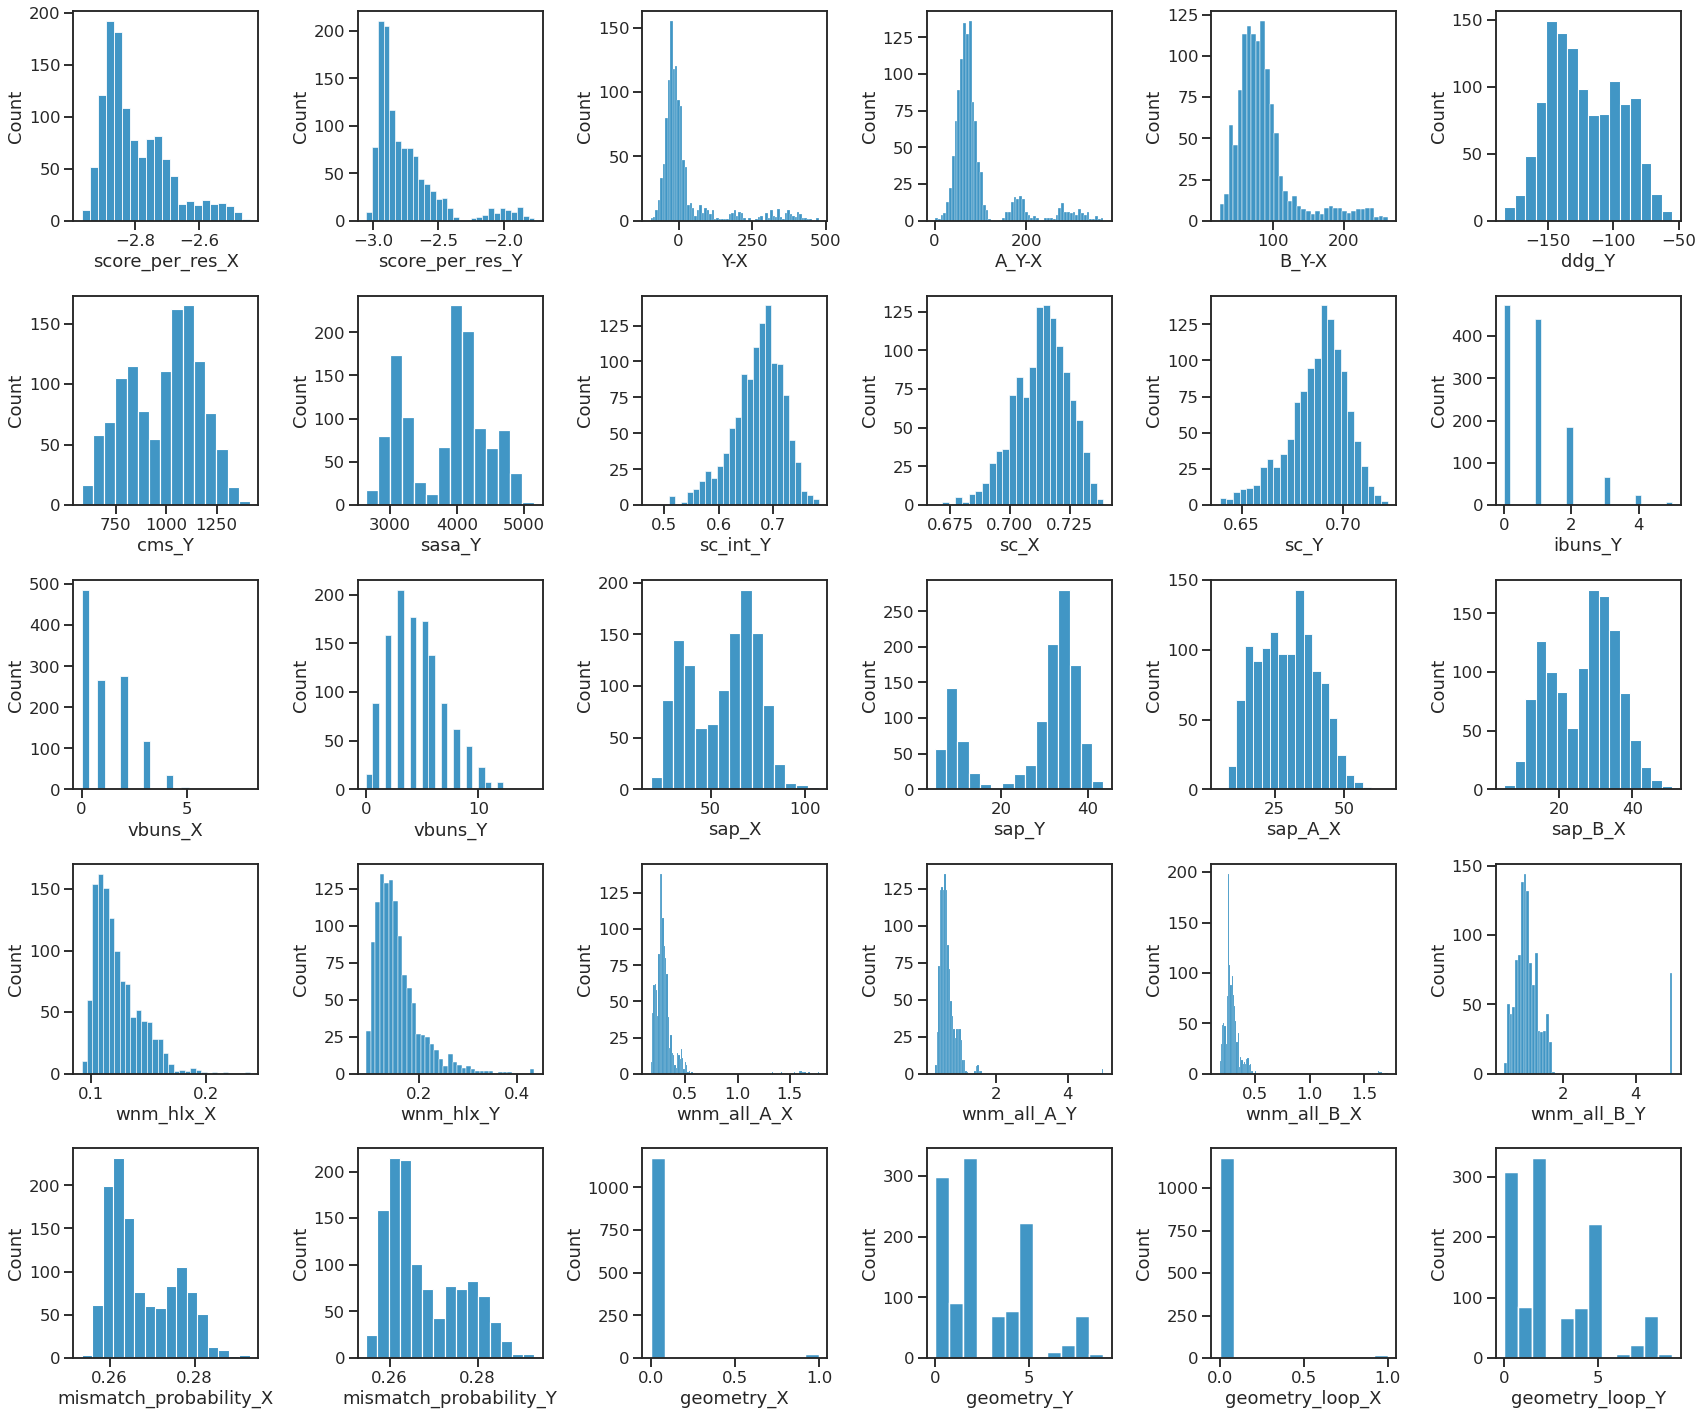

In [26]:
histplot_df(scores_df)

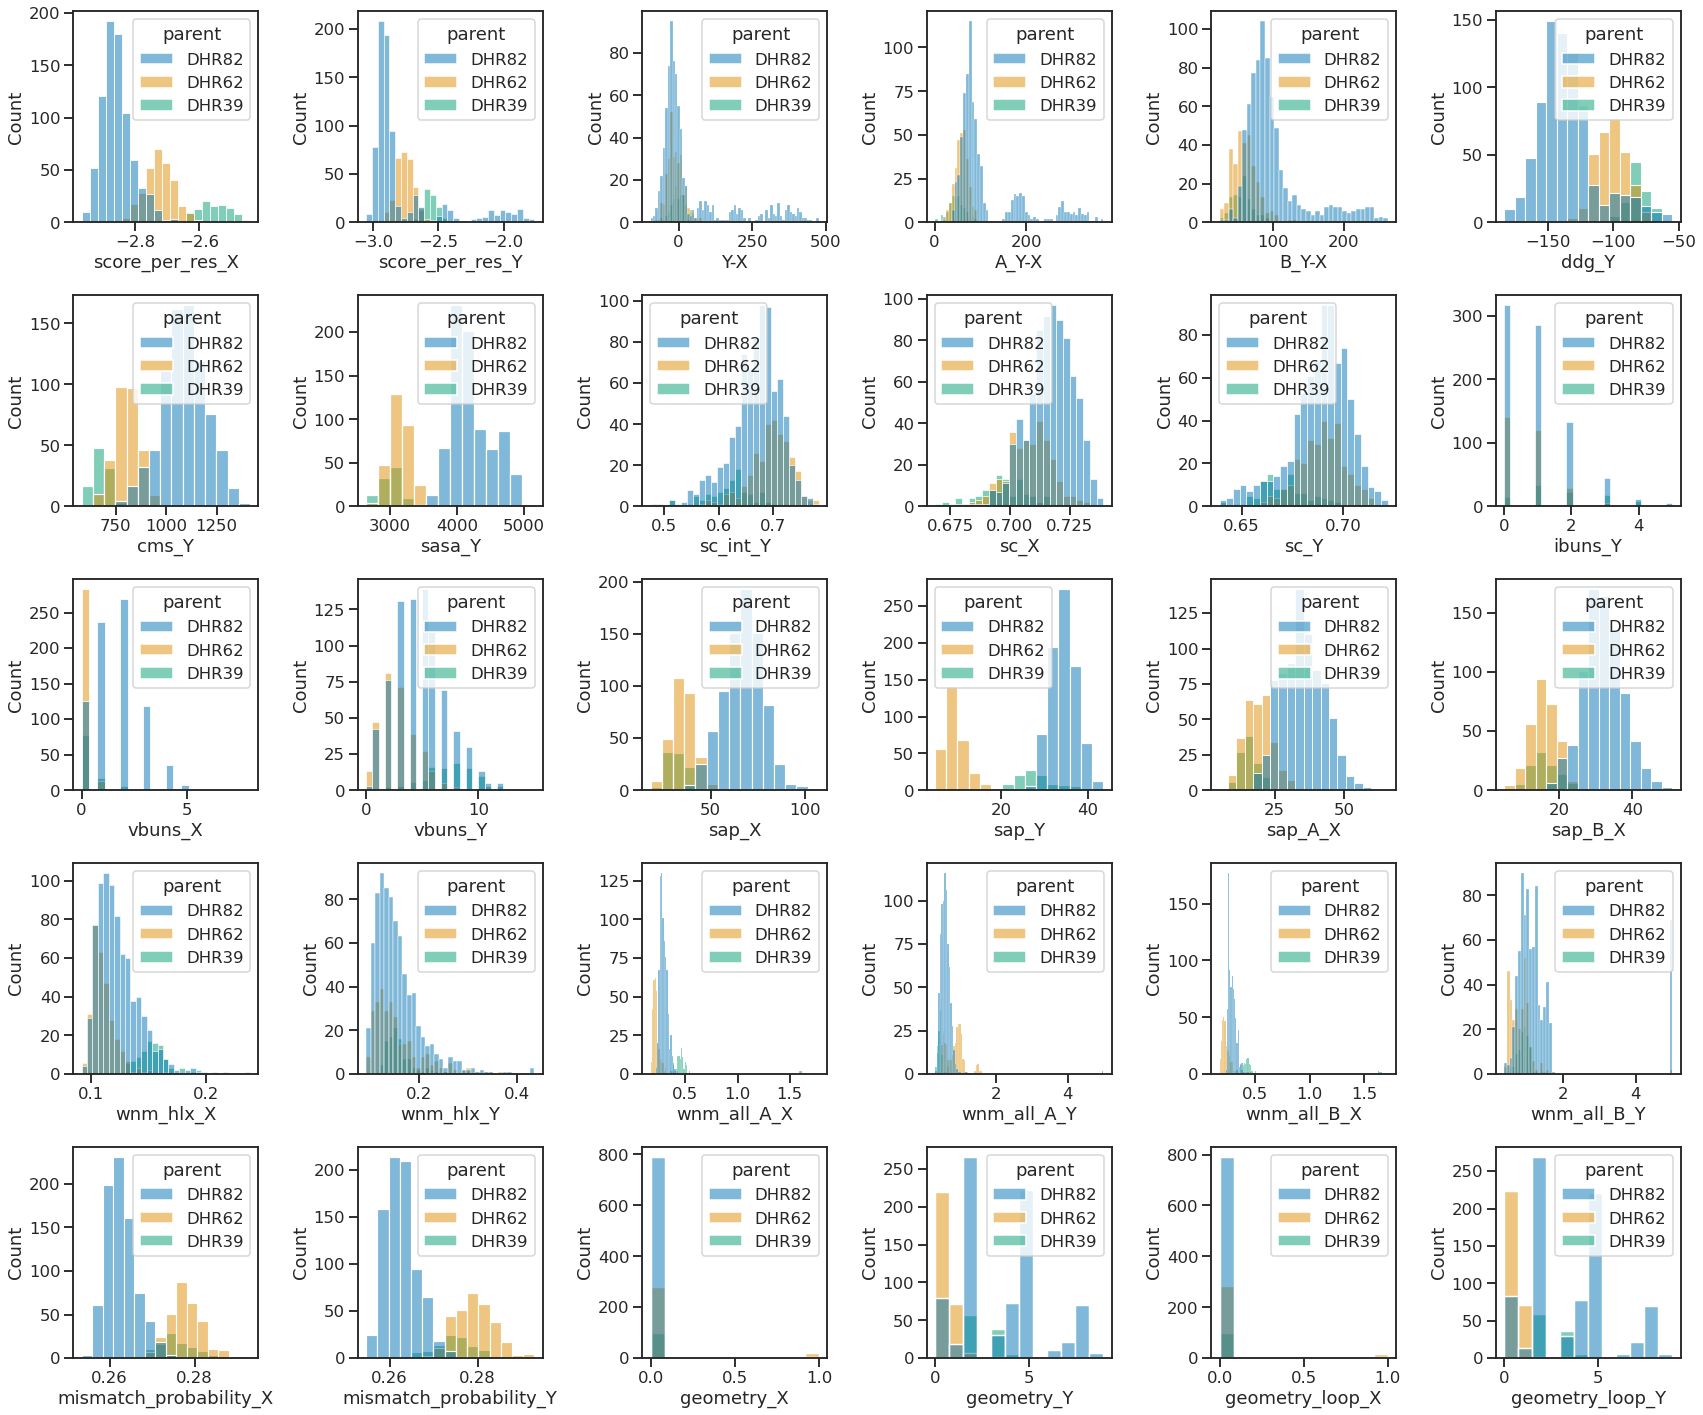

In [27]:
histplot_df(scores_df, 'parent', ['DHR82', 'DHR62', 'DHR39'])

In [28]:
# Filter designs- global filter

cutoffs = [('Y-X', -20, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.7, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 3, 0),
]

global_df = filter_df(scores_df, cutoffs)
print_scores(global_df)

19


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/design_decoys/86f2828056958eed292fdacd91fe225d81314c128e5874cd.pdb,-2.687195,-2.752733,-22.545044,59.463928,46.182648,-107.516693,784.570251,2975.905518,0.729689,0.710736,0.705068,1,0,1,32.616364,6.531330,15.658974,16.957403,0.107958,0.139175,0.199012,0.930259,0.216584,0.558054,0.283217,0.284422,1,0,1,0,DHR62
05_two_state/run_3/design_decoys/f7f1932ae0410b3592ecae2e754da46cf79be50132a3f454.pdb,-2.763138,-2.838710,-25.996765,45.079376,80.287415,-106.944656,882.016663,3434.031494,0.708998,0.711101,0.694341,1,0,2,35.017315,7.802075,21.270836,13.746485,0.102299,0.141901,0.223305,0.548952,0.221458,0.501542,0.273146,0.274938,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/c2e001d81f6cc1b303d1909d8846cbad5b4a9757d594c25e.pdb,-2.720272,-2.880824,-55.229736,37.136414,41.517792,-112.235123,832.071655,3169.055420,0.724633,0.716005,0.708170,0,0,2,45.186764,7.846912,24.414001,20.772736,0.106142,0.161062,0.308798,0.597119,0.248520,0.961729,0.277917,0.274192,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/540210c96a1ce895d2add7e3a5079f5aa4499a7759244ed3.pdb,-2.729673,-2.877644,-50.902039,34.458588,54.824097,-110.422997,832.236145,3158.826172,0.732073,0.703960,0.706053,2,0,1,52.417675,9.200109,31.208195,21.209478,0.119658,0.103079,0.220996,0.908276,0.214827,0.678074,0.278932,0.284056,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/be59246e09ed1252571786185f85f5b0ec7eabfee7dbf4c0.pdb,-2.694967,-2.823668,-44.273071,52.320496,42.762085,-108.701973,797.281250,3101.592041,0.715222,0.706692,0.695387,1,0,2,38.567154,8.237868,20.587631,17.979530,0.113999,0.181052,0.200546,0.438847,0.263509,0.965855,0.279958,0.279915,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/8422beee5ab47d1d484444fdc0350a14dc89faae01ac23bd.pdb,-2.619578,-2.766407,-50.509460,52.576141,28.566711,-107.401031,798.668152,3152.038330,0.718195,0.696874,0.696588,0,0,2,37.814850,7.586836,19.863037,17.951820,0.111766,0.153375,0.203276,0.901142,0.262605,0.532155,0.278390,0.280375,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/a80538129a0d2484be898b4cbef2770596ce554a1f0ecb4b.pdb,-2.728842,-2.796079,-23.129578,66.522766,43.094635,-117.346596,827.744263,3128.877197,0.703429,0.720351,0.685404,0,0,2,30.303288,9.588267,16.223612,14.079676,0.119609,0.176855,0.205242,0.930745,0.189024,0.674720,0.280392,0.277153,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/03d9c3092f8f7cb57d56bd0605974a6126f1e9d0763e954c.pdb,-2.760713,-2.842582,-28.162903,42.058319,68.329712,-116.971024,876.817017,3291.858398,0.735491,0.704800,0.693160,0,0,1,34.517883,10.093174,23.252262,11.265616,0.101644,0.184789,0.242018,0.486325,0.191844,0.765169,0.284462,0.283460,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/2ce3580dd03b5ff09124189f99757a3a04818e0d9551c096.pdb,-2.719156,-2.845032,-43.301514,63.835083,26.441467,-115.606438,788.934021,3000.018066,0.724510,0.701970,0.680341,0,0,2,30.990829,6.903338,15.586828,15.404024,0.107390,0.184318,0.211384,0.693028,0.274059,0.901533,0.274211,0.274568,0,0,0,0,DHR62
05_two_state/run_3/design_decoys/577be455c381ccf0b9bc420c78c8e6ffb79c0171cba0da03.pdb,-2.767051,-2.842147,-25.833069,51.597748,66.373505,-117.815361,841.106018,3212.830078,0.724465,0.706246,0.696369,1,0,1,39.767506,7.683999,22.542536,17.224991,0.106860,0.119217,0.212822,0.569516,0.211209,0.762114,0.282636,0.279806,0,0,0,0,DHR62


In [34]:
# Filter designs- global filter

cutoffs = [('Y-X', -10, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('sc_int_Y', 0.62, 1),
           ('wnm_hlx_X', 0.2, 0),
           ('wnm_hlx_Y', 0.2, 0),
           ('wnm_all_A_X', 1, 0),
           ('wnm_all_B_X', 1, 0),
           ('wnm_all_A_Y', 1, 0),
           ('wnm_all_B_Y', 1, 0),
           ('vbuns_X', 3, 0),
           ('vbuns_Y', 5, 0),
]

global_df_2 = filter_df(scores_df, cutoffs)
print_scores(global_df_2[global_df_2['parent']=='DHR82'])
print_scores(global_df_2[global_df_2['parent']=='DHR39'])

74


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/design_decoys/e57cbb4166a714a6cc1788ffbb4bb9a3c6e1c6f34d7548b1.pdb,-2.893146,-2.916123,-10.661377,87.394409,94.622864,-143.512787,1237.400146,4802.498047,0.702268,0.715211,0.693222,0,2,3,58.702877,34.837379,27.800390,30.902496,0.120710,0.110219,0.339968,0.536169,0.255282,0.863865,0.271931,0.272777,0,5,0,5,DHR82
05_two_state/run_3/design_decoys/b3a08966cd58dddcf4130c1903eaa03331d4e681112a4b6c.pdb,-2.835348,-2.993979,-73.604248,55.603516,62.257263,-158.095932,1188.548828,4516.045898,0.712920,0.726135,0.700626,1,2,3,62.084476,32.953121,32.941582,29.142948,0.132143,0.134126,0.344572,0.621581,0.289309,0.868151,0.261611,0.262364,0,5,0,5,DHR82
05_two_state/run_3/design_decoys/24275ce3243a4c97285feba55c704f7a921861430cfc4dae.pdb,-2.877897,-2.958343,-37.327026,60.633850,66.145996,-134.114365,996.915161,4045.497070,0.649804,0.703353,0.675090,0,0,4,65.947067,32.586559,34.252979,31.694080,0.111534,0.184130,0.290134,0.500421,0.249429,0.955211,0.259875,0.259571,0,2,0,2,DHR82
05_two_state/run_3/design_decoys/986fa7cf303f2fba9f30949dc1bd4bb9e3bd0e76953be91b.pdb,-2.875448,-2.953674,-36.296509,69.845703,76.351868,-148.257080,1106.953979,4338.972168,0.685599,0.728799,0.691142,0,1,2,59.588589,34.482891,25.446442,34.142143,0.103659,0.176886,0.285343,0.501498,0.244853,0.798449,0.260665,0.260814,0,2,0,2,DHR82


,score_per_res_X,score_per_res_Y,Y-X,A_Y-X,B_Y-X,ddg_Y,cms_Y,sasa_Y,sc_int_Y,sc_X,sc_Y,ibuns_Y,vbuns_X,vbuns_Y,sap_X,sap_Y,sap_A_X,sap_B_X,wnm_hlx_X,wnm_hlx_Y,wnm_all_A_X,wnm_all_A_Y,wnm_all_B_X,wnm_all_B_Y,mismatch_probability_X,mismatch_probability_Y,geometry_X,geometry_Y,geometry_loop_X,geometry_loop_Y,parent
05_two_state/run_3/design_decoys/9c3f79bc34f39a9d520cac5334dd383bc44aa65e75af9e19.pdb,-2.573272,-2.625954,-17.701416,35.803772,58.675568,-89.587158,706.011597,3071.929443,0.628435,0.698708,0.673496,5,0,3,24.729521,22.436226,13.544860,11.184661,0.180279,0.153086,0.439209,0.435905,0.504436,0.995755,0.272674,0.270233,0,2,0,2,DHR39
05_two_state/run_3/design_decoys/afc05ef4d2872861bc32e74b7aa89b93110af9c199a8bfd1.pdb,-2.559806,-2.599565,-13.359070,64.760254,27.375671,-81.182831,681.089966,2999.903320,0.640523,0.698782,0.669909,2,0,4,37.810616,33.884972,18.857870,18.952751,0.155683,0.156491,0.500961,0.475298,0.432792,0.881821,0.274776,0.275272,0,2,0,2,DHR39
05_two_state/run_3/design_decoys/dfec019ce38e1efea94ba3fdf280334c1f9d04c3fad52e6b.pdb,-2.521029,-2.557973,-12.412903,37.547699,61.989563,-78.804871,718.981079,3099.015869,0.632036,0.694189,0.664882,2,0,4,25.500387,28.159002,12.047277,13.453092,0.154970,0.130758,0.466944,0.420649,0.437758,0.954487,0.280400,0.278478,0,3,0,3,DHR39


In [35]:
# Copy best designs to a folder

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected/des_DHR62/'
copy_designs(global_df, out_dir)

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected/des_DHR82/'
copy_designs(global_df_2[global_df_2['parent']=='DHR82'], out_dir)

out_dir = '/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected/des_DHR39/'
copy_designs(global_df_2[global_df_2['parent']=='DHR39'], out_dir)

In [37]:
# Generate list to alphafold

cutoffs = [('Y-X', 100, 0),
           ('sap_A_X', 35, 0),
           ('sap_B_X', 35, 0),
           ('sap_Y', 40, 0),
           ('vbuns_X', 4, 0),
           ('vbuns_Y', 5, 0),
]

af_df = filter_df(scores_df, cutoffs)

with open('05_two_state/run_3/des_selected.list', 'w') as f:
    for index, row in af_df.iterrows():
        f.write(index + '\n')

323


In [41]:
# Save pdbs with only the dimer for alphafolding

pyrosetta.distributed.maybe_init(**{
    "options": "-corrections::beta_nov16 true",
    "extra_options":{
        "-out:level": "100"
}})

keep_dimer = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()
keep_dimer.chain_order("34")

with open('05_two_state/run_3/af2_selected.list', 'r') as sel_f:
    for line in sel_f:
        pdb_file = line.rstrip()
        pose = pyrosetta.pose_from_pdb(pdb_file)
        keep_dimer.apply(pose)
        pose.dump_pdb('05_two_state/run_3/selected_for_af2/af2_dimer_pdbs/' + pdb_file.split('/')[-1])
with open('05_two_state/run_3/des_selected.list', 'r') as sel_f:
    for line in sel_f:
        pdb_file = line.rstrip()
        pose = pyrosetta.pose_from_pdb(pdb_file)
        keep_dimer.apply(pose)
        pose.dump_pdb('05_two_state/run_3/selected_for_af2/des_dimer_pdbs/' + pdb_file.split('/')[-1])

In [43]:
from glob import glob
print(f"silentfrompdbs {glob('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected_for_af2/des_dimer_pdbs/*.pdb')[0]} > /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected_for_af2/des_selected_test.silent\n")

silentfrompdbs /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected_for_af2/des_dimer_pdbs/1f6baf515c08a9bfe2f66427a68912da1b9aafabd56187d6.pdb > /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected_for_af2/des_selected_test.silent



In [44]:
!silentfrompdbs /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected_for_af2/des_dimer_pdbs/1f6baf515c08a9bfe2f66427a68912da1b9aafabd56187d6.pdb > /home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/05_two_state/run_3/selected_for_af2/des_selected_test.silent

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.44+release.de9edbfaf502e0b00debd50df9e9c36eb454838a 2021-11-02T20:42:19] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags 
core.init: Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release r301 2021.44+release.de9edbf de9edbfaf502e0b00debd50df9e9c36eb454838a http://www.pyrosetta.org 2021-11-02T20:42:19
core.init: command: PyRosetta -l tmp_zB4PErcemRECF.list -out:file:silent tmp_JlUyw2DZahyYn.silent -out:file:silent_struct_type binary -extra_res_fa /home/bcov/from/jason/H3i.am1bcc.fa.mm.params -database /projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-892470131 seed_offset=